In [1]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

import mdtraj as md
import numpy as np
import os

import MDAnalysis as mda
import nglview as nv

import pandas as pd

import gmxapi as gmx
import glob
from scipy import stats

import itertools

In [2]:
from manuscript import *

<Figure size 432x288 with 0 Axes>

In [3]:
sns.set(style="ticks",context='paper',font_scale=2.5)

# Analysis

# Sodium + Chloride

In [4]:
from NACHRA7_annotations import *

In [5]:
traj_note_dic = {'traj_note': ['NACHRA7_NOPNU_EPJ_POPC_CAM'],
                 'load_location': ["".join(i) for i in itertools.product([default_load_location],
                                                                ['NACHRA7_NOPNU_EPJ_POPC_CAM'],
                                                                ['/EF_200_5CA/',
                                                                 '/EF_200_0CA/',
                                                                 '/EF_200_150CA/',
                                                                 '/EF_200_150CA_0NA'])],
                 'skip': [default_skip] * 4,
                 'rep': [default_rep] * 4}

In [6]:
traj_note_dic

{'traj_note': ['NACHRA7_NOPNU_EPJ_POPC_CAM'],
 'load_location': ['/mnt/cephfs/projects/2020100800_alpha7_nachrs/SIMULATIONS/NACHRA7_NOPNU_EPJ_POPC_CAM/EF_200_5CA/',
  '/mnt/cephfs/projects/2020100800_alpha7_nachrs/SIMULATIONS/NACHRA7_NOPNU_EPJ_POPC_CAM/EF_200_0CA/',
  '/mnt/cephfs/projects/2020100800_alpha7_nachrs/SIMULATIONS/NACHRA7_NOPNU_EPJ_POPC_CAM/EF_200_150CA/',
  '/mnt/cephfs/projects/2020100800_alpha7_nachrs/SIMULATIONS/NACHRA7_NOPNU_EPJ_POPC_CAM/EF_200_150CA_0NA'],
 'skip': [1, 1, 1, 1],
 'rep': [4, 4, 4, 4]}

In [7]:
def create_md_dataframe():    
    return pd.DataFrame(columns=list(['MD_name','replicate','frame','traj_time','system','id','ligand','note']))

In [8]:
def append_metadata(traj_note, rep, ident, system, location, skip = default_skip):
    rep_data = []
    traj_note_split = traj_note.split('_')
    top_location = '/' + "init.pdb"
    traj_location = '/rep' + rep + '/' + "ef.xtc"
    traj = mda.Universe(location + top_location,
                        location + traj_location)         
    md_name = traj_note_split[0]
    ligand = traj_note_split[1:-1] ##in this case
    timestep = 2
    note = traj_note_split[-1]
    n_frames = traj.trajectory.n_frames
    ts = traj.trajectory.dt
    for i in range(n_frames):
        rep_data.append([md_name, rep, i,  ts * i, system, ident,ligand,note])

    return rep_data
    
    
meta_data = Parallel(n_jobs=num_cores)(delayed(append_metadata)(traj_note = traj_note_dic['traj_note'][0], 
                                                        rep = str(i%4 + 1),
                                                        ident = i,
                                                        system = i//4,
                                                        location = traj_note_dic['load_location'][i//4],
                                                        skip = traj_note_dic['skip'][i//4], 
                                               )
                           for i in range(0, np.sum(traj_note_dic['rep'])))
md_data = create_md_dataframe()
for i in range(0, np.sum(traj_note_dic['rep'])):
    md_data = md_data.append(pd.DataFrame(meta_data[i],columns=list(['MD_name','replicate','frame','traj_time','system','id','ligand','note'])),ignore_index=True)
md_data['frame'] =md_data['frame'].apply(int)
md_data['traj_time'] =md_data['traj_time'].apply(float)
md_data['replicate'] =md_data['replicate'].apply(int)
md_data['system'] = md_data['system'].apply(int)

<ipython-input-8-6c6d0fcf7383>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  md_data = md_data.append(pd.DataFrame(meta_data[i],columns=list(['MD_name','replicate','frame','traj_time','system','id','ligand','note'])),ignore_index=True)
<ipython-input-8-6c6d0fcf7383>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  md_data = md_data.append(pd.DataFrame(meta_data[i],columns=list(['MD_name','replicate','frame','traj_time','system','id','ligand','note'])),ignore_index=True)
<ipython-input-8-6c6d0fcf7383>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  md_data = md_data.append(pd.DataFrame(meta_data[i],columns=list(['MD_name','replicate','frame','traj_time','system','id','ligand','note'])),ignore_index=True)
<ipython-inpu

In [9]:
def append_all_ion_info(ion, traj_note, rep, system, location):
    def cartesian_to_cylinder(posx, posy, princ_x, princ_y):
        return np.sqrt((posx - princ_x) ** 2 + (posy - princ_y) ** 2)
    
    ion_data = []
    traj_note_split = traj_note.split('_')
    top_location = location + '/' + "init.pdb"
    traj_location = location + '/rep' + rep + '/' + "ef.xtc"
    traj = mda.Universe(top_location,
                        traj_location)

    if ion == 'CAM':
        ion_ag = traj.select_atoms(f'resname {ion} and name D0 or resname CAL')
    else:
        ion_ag = traj.select_atoms(f'resname {ion}')

    princ_center_ch = np.mean(traj.select_atoms('resid 247 and name CA').positions[:5],axis=0)

    for ts in traj.trajectory[:md_data[(md_data.system==system)&(md_data.replicate==eval(rep))]['frame'].max()+1]:
        position_x = ion_ag.positions.T[0]
        position_y = ion_ag.positions.T[1]
        position_z = ion_ag.positions.T[2] - princ_center_ch[2]
#        position_r = cartesian_to_cylinder(position_x, position_y, princ_center_ch[0], princ_center_ch[1])

        ion_data.append(np.asarray([position_x,
                                    position_y,
                                    position_z,
                                    ]).T)
    return ion_data


for ion in ['SOD', 'CAM', 'CLA']:    
    ion_data = Parallel(n_jobs=num_cores)(delayed(append_all_ion_info)(
                                                        ion = ion,
                                                        traj_note = traj_note_dic['traj_note'][0], 
                                                        rep = str(i%4 + 1),
                                                        system = int(i/4),
                                                        location = traj_note_dic['load_location'][i//4])
                           for i in range(0, np.sum(traj_note_dic['rep'])))

    ion_data_concat = [x for x in ion_data if x != []]
    md_data[ion + '_data'] = [item for sublist in ion_data_concat for item in sublist]

In [ ]:
for (i, ((sys, ind), df)) in enumerate(md_data.groupby(['system','replicate'])):
    fig, ax = plt.subplots(figsize=(40,10),gridspec_kw={'wspace': 0.3})

    ion_all = df['CAM' + '_data'].apply(lambda x: np.array(x)).to_numpy()
    ion_arr_all = np.concatenate(ion_all).reshape(df.shape[0],ion_all[0].shape[0],3).transpose((1,0,2))
    for single_ion in ion_arr_all:
        z_coord = single_ion.T[2].ravel()
        time = df['traj_time'].ravel()
        #time = time[np.where(np.logical_and(z_coord>=60, z_coord<=120))]
        time = np.ma.masked_where(z_coord<=-80, time)

        z_coord = np.ma.masked_where(z_coord<=-80, z_coord)
        ax.plot(time,
                z_coord)

    ax.set_title('CAM rep ' + str(ind))
    ax.set_ylim(-25,25)
    plt.show()

In [10]:
system = ['/EF_200_5CA/',
          '/EF_200_0CA/',
          '/EF_200_150CA/',
          '/EF_200_150CA_0NA']

In [31]:
u = mda.Universe('../SIMULATIONS/NACHRA7_NOPNU_EPJ_POPC_CAM/ca.pdb')

/nethome/yzhuang/mdanalysis/package/MDAnalysis/topology/PDBParser.py:340: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/nethome/yzhuang/mdanalysis/package/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [32]:
ions = u.select_atoms('resname CAM').residues

In [11]:
threshold_middle = 3
threshold_time = 100

In [13]:
print('For Sodium,')
for (i, ((sys, ind), df)) in enumerate(md_data.groupby(['system','replicate'])):
#    conduct_list = []
    permeation_event = 0
    df = md_data[(md_data.system == sys) & (md_data.replicate == ind)]
    time = md_data[(md_data.system == sys) & (md_data.replicate == ind)].shape[0] * 40 / 1000
    ion_all = df['SOD' + '_data'].apply(lambda x: np.array(x)).to_numpy()
    ion_all = df['SOD' + '_data'].apply(lambda x: np.array(x)).to_numpy()
    ion_arr_all = np.concatenate(ion_all).reshape(df.shape[0],ion_all[0].shape[0],3).transpose((1,0,2))
    for ion_single in ion_arr_all:
        ion_z_single = ion_single.T[2]
        mask = (ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle)
        if mask.any():
            middle_points = np.argwhere((ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle))
            for middle_p in middle_points:
                try:
                    if np.sign(ion_z_single[middle_p-threshold_time]) != np.sign(ion_z_single[middle_p+threshold_time]):
                        permeation_event += 1
                        break
                except:
                    pass
            
    columb_e_conv = 6.242E18
    vmemb = 0.2
    conductance = permeation_event / columb_e_conv / (time * 1e-9) / vmemb * 1e12
    print('In sys', sys, 'in rep', ind, 'time', time, 'ns, permeation', permeation_event, 'conductance', conductance, 'pS')
#    conduct_list.append(conductance)
#    print('Conductance avg:', np.mean(conductance), '+-', np.var(conductance))
print('')

For Sodium,
In sys 0 in rep 1 time 411.56 ns, permeation 54 conductance 105.10099832246348 pS
In sys 0 in rep 2 time 408.72 ns, permeation 48 conductance 94.07226217262146 pS
In sys 0 in rep 3 time 410.96 ns, permeation 65 conductance 126.69516572413778 pS
In sys 0 in rep 4 time 409.84 ns, permeation 70 conductance 136.81380994532265 pS
In sys 1 in rep 1 time 321.84 ns, permeation 50 conductance 124.44464833455628 pS
In sys 1 in rep 2 time 321.36 ns, permeation 57 conductance 142.07879887600416 pS
In sys 1 in rep 3 time 320.12 ns, permeation 63 conductance 157.64274235034335 pS
In sys 1 in rep 4 time 324.64 ns, permeation 49 conductance 120.90389449110926 pS
In sys 2 in rep 1 time 251.16 ns, permeation 9 conductance 28.70372595795049 pS
In sys 2 in rep 2 time 250.56 ns, permeation 15 conductance 47.95410155650573 pS
In sys 2 in rep 3 time 248.84 ns, permeation 11 conductance 35.40941342388117 pS
In sys 2 in rep 4 time 260.44 ns, permeation 10 conductance 30.756616203343256 pS
In sys 3 

In [14]:
print('For Sodium,')

for (i, ((sys), sys_df)) in enumerate(md_data.groupby(['system'])):
    conduct_list = []

    for (j, (ind, df)) in enumerate(sys_df.groupby(['replicate'])):
        permeation_event = 0
        df = md_data[(md_data.system == sys) & (md_data.replicate == ind)]
        time = md_data[(md_data.system == sys) & (md_data.replicate == ind)].shape[0] * 40 / 1000
        ion_all = df['SOD' + '_data'].apply(lambda x: np.array(x)).to_numpy()
        ion_arr_all = np.concatenate(ion_all).reshape(df.shape[0],ion_all[0].shape[0],3).transpose((1,0,2))
        for ion_single in ion_arr_all:
            ion_z_single = ion_single.T[2]
            mask = (ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle)
            if mask.any():
                middle_points = np.argwhere((ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle))
                for middle_p in middle_points:
                    try:
                        if np.sign(ion_z_single[middle_p-threshold_time]) != np.sign(ion_z_single[middle_p+threshold_time]):
                            permeation_event += 1
                            break
                    except:
                        pass

        columb_e_conv = 6.242E18
        vmemb = 0.2
        conductance = permeation_event / columb_e_conv / (time * 1e-9) / vmemb * 1e12
        #print('In sys', sys, 'in rep', ind, 'time', time, 'ns, permeation', permeation_event, 'conductance', conductance, 'pS')
        conduct_list.append(conductance)
    print(system[sys])
    print('Conductance avg:', np.mean(conduct_list), '+-',  np.std(conduct_list), 'pS')
    print('')

For Sodium,
/EF_200_5CA/
Conductance avg: 115.67055904113634 +- 16.93207793448922 pS

/EF_200_0CA/
Conductance avg: 136.26752101300326 +- 14.718121278684794 pS

/EF_200_150CA/
Conductance avg: 35.705964285420166 +- 7.477168532557603 pS

/EF_200_150CA_0NA
Conductance avg: 0.0 +- 0.0 pS



In [15]:
print('For Calcium,')
for (i, ((sys), sys_df)) in enumerate(md_data.groupby(['system'])):
    conduct_list = []

    for (j, (ind, df)) in enumerate(sys_df.groupby(['replicate'])):
        permeation_event = 0
        df = md_data[(md_data.system == sys) & (md_data.replicate == ind)]
        time = md_data[(md_data.system == sys) & (md_data.replicate == ind)].shape[0] * 40 / 1000
        ion_all = df['CAM' + '_data'].apply(lambda x: np.array(x)).to_numpy()
        ion_arr_all = np.concatenate(ion_all).reshape(df.shape[0],ion_all[0].shape[0],3).transpose((1,0,2))
        for ion_single in ion_arr_all:
            ion_z_single = ion_single.T[2]
            mask = (ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle)
            if mask.any():
                middle_points = np.argwhere((ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle))
                for middle_p in middle_points:
                    try:
                        if np.sign(ion_z_single[middle_p-threshold_time]) != np.sign(ion_z_single[middle_p+threshold_time]):
                            permeation_event += 1
                            break
                    except:
                        pass

        columb_e_conv = 6.242E18
        vmemb = 0.2
        conductance = permeation_event * 2 / columb_e_conv / (time * 1e-9) / vmemb * 1e12
        #print('In sys', sys, 'in rep', ind, 'time', time, 'ns, permeation', permeation_event, 'conductance', conductance, 'pS')
        conduct_list.append(conductance)
    print(system[sys])
    print('Conductance avg:', np.mean(conduct_list), '+-',  np.std(conduct_list), 'pS')
    print('')

For Calcium,
/EF_200_5CA/
Conductance avg: 0.0 +- 0.0 pS

/EF_200_0CA/
Conductance avg: 0.0 +- 0.0 pS

/EF_200_150CA/
Conductance avg: 76.09288328417966 +- 8.020807291378908 pS

/EF_200_150CA_0NA
Conductance avg: 66.35855238592757 +- 12.651591409901288 pS



In [ ]:
md_data['direction'] = md_data.system.apply(lambda x: 'up' if x%2 == 0 else 'down')

In [ ]:
for (i, ((sys, ind), df)) in enumerate(md_data.groupby(['system','replicate'])):
    permeation_event = 0
    df = md_data[(md_data.system == sys) & (md_data.replicate == ind)]
    time = md_data[(md_data.system == sys) & (md_data.replicate == ind)].shape[0] * 40 / 1000
    ion_all = df['CLA' + '_data'].apply(lambda x: np.array(x)).to_numpy()
    ion_arr_all = np.concatenate(ion_all).reshape(df.shape[0],ion_all[0].shape[0],3).transpose((1,0,2))
    for ion_single in ion_arr_all:
        ion_z_single = ion_single.T[2]
        mask = (ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle)
        if mask.any():
            middle_points = np.argwhere((ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle))
            for middle_p in middle_points:
                try:
                    if np.sign(ion_z_single[middle_p-threshold_time]) != np.sign(ion_z_single[middle_p+threshold_time]):
                        permeation_event += 1
                        break
                except:
                    pass
             
    columb_e_conv = 6.242E18
    vmemb = 0.2
    conductance = permeation_event / columb_e_conv / (time * 1e-9) / vmemb * 1e12
    print('In sys', sys, 'in rep', ind, 'time', time, 'ns, permeation', permeation_event, 'conductance', conductance, 'pS')
print('')

In [ ]:
for (i, ((sys), sys_df)) in enumerate(md_data.groupby(['system'])):
    conduct_list = []

    for (j, (ind, df)) in enumerate(sys_df.groupby(['replicate'])):
        permeation_event = 0
        df = md_data[(md_data.system == sys) & (md_data.replicate == ind)]
        time = md_data[(md_data.system == sys) & (md_data.replicate == ind)].shape[0] * 40 / 1000
        ion_all = df['CLA' + '_data'].apply(lambda x: np.array(x)).to_numpy()
        ion_arr_all = np.concatenate(ion_all).reshape(df.shape[0],ion_all[0].shape[0],3).transpose((1,0,2))
        for ion_single in ion_arr_all:
            ion_z_single = ion_single.T[2]
            mask = (ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle)
            if mask.any():
                middle_points = np.argwhere((ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle))
                for middle_p in middle_points:
                    try:
                        if np.sign(ion_z_single[middle_p-threshold_time]) != np.sign(ion_z_single[middle_p+threshold_time]):
                            permeation_event += 1
                            break
                    except:
                        pass

        columb_e_conv = 6.242E18
        vmemb = 0.2
        conductance = permeation_event / columb_e_conv / (time * 1e-9) / vmemb * 1e12
        #print('In sys', sys, 'in rep', ind, 'time', time, 'ns, permeation', permeation_event, 'conductance', conductance, 'pS')
        conduct_list.append(conductance)
    print(system[sys])

    print('Conductance avg:', np.mean(conduct_list), '+-',  np.std(conduct_list), 'pS')
    print('')

In [ ]:
for (i, ((sys), sys_df)) in enumerate(md_data.groupby(['system'])):
    conduct_list = []

    for (j, (ind, df)) in enumerate(sys_df.groupby(['replicate'])):
        permeation_event = 0
        df = md_data[(md_data.system == sys) & (md_data.replicate == ind)]
        time = md_data[(md_data.system == sys) & (md_data.replicate == ind)].shape[0] * 40 / 1000
        ion_all = df['CAL' + '_data'].apply(lambda x: np.array(x)).to_numpy()
        ion_arr_all = np.concatenate(ion_all).reshape(df.shape[0],ion_all[0].shape[0],3).transpose((1,0,2))
        for ion_single in ion_arr_all:
            ion_z_single = ion_single.T[2]
            mask = (ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle)
            if mask.any():
                middle_points = np.argwhere((ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle))
                for middle_p in middle_points:
                    try:
                        if np.sign(ion_z_single[middle_p-threshold_time]) != np.sign(ion_z_single[middle_p+threshold_time]):
                            permeation_event += 1
                            break
                    except:
                        pass

        columb_e_conv = 6.242E18
        vmemb = 0.2
        conductance = permeation_event / columb_e_conv / (time * 1e-9) / vmemb * 1e12
        #print('In sys', sys, 'in rep', ind, 'time', time, 'ns, permeation', permeation_event, 'conductance', conductance, 'pS')
        conduct_list.append(conductance)
    print(system[sys])

    print('Conductance avg:', np.mean(conduct_list), '+-',  np.std(conduct_list), 'pS')
    print('')

In [ ]:
for (i, ((sys, ind), df)) in enumerate(md_data.groupby(['system','replicate'])):
    fig, ax = plt.subplots(figsize=(40,10),gridspec_kw={'wspace': 0.3})

    ion_all = df['SOD' + '_data'].apply(lambda x: np.array(x)).to_numpy()
    ion_arr_all = np.concatenate(ion_all).reshape(df.shape[0],ion_all[0].shape[0],3).transpose((1,0,2))
    for single_ion in ion_arr_all:
        z_coord = single_ion.T[2].ravel()
        time = df['traj_time'].ravel()
        #time = time[np.where(np.logical_and(z_coord>=60, z_coord<=120))]
        time = np.ma.masked_where(z_coord<=-80, time)

        z_coord = np.ma.masked_where(z_coord<=-80, z_coord)
        ax.plot(time,
                z_coord)

    ax.set_title('SOD rep ' + str(ind))
    ax.set_ylim(-55,55)
    plt.show()

In [51]:
md_data.to_pickle('ef_new.pickle')

In [ ]:
md_data = pd.read_pickle('ef.pickle')

In [16]:
def create_md_dataframe():    
    return pd.DataFrame(columns=list(['MD_name','replicate','traj_time','system','id','ligand','note']))

In [17]:
def append_metadata(traj_note, rep, ident, system, location, skip = default_skip):
    rep_data = []
    traj_note_split = traj_note.split('_')
    top_location = '/' + "init.pdb"
    traj_location = '/rep' + rep + '/' + "ef.xtc"
    traj = mda.Universe(location + top_location,
                        location + traj_location)         
    md_name = traj_note_split[0]
    if location.split('/')[-1] == '': 
        ligand = location.split('/')[-3]
        note = location.split('/')[-2]
    else:
        ligand = location.split('/')[-2]
        note = location.split('/')[-1]        

    timestep = 2
    n_frames = traj.trajectory.n_frames
    ts = traj.trajectory.dt
    rep_data.append([md_name, rep, ts * n_frames, system, ident,ligand,note])

    return rep_data
    
    
meta_data = Parallel(n_jobs=num_cores)(delayed(append_metadata)(traj_note = traj_note_dic['traj_note'][0], 
                                                        rep = str(i%4 + 1),
                                                        ident = i,
                                                        system = i//4,
                                                        location = traj_note_dic['load_location'][i//4],
                                                       skip = traj_note_dic['skip'][i//4], 
                                               )
                           for i in range(0, np.sum(traj_note_dic['rep'])))

In [19]:
ef_data = create_md_dataframe()
for i in range(0,np.sum(traj_note_dic['rep'])):
    ef_data = pd.concat([ef_data,
    pd.DataFrame(meta_data[i],columns=list(ef_data.columns))],ignore_index=True)
ef_data['traj_time'] = ef_data['traj_time'].apply(float)
ef_data['replicate'] = ef_data['replicate'].apply(int)
ef_data['system'] = ef_data['system'].apply(int)

In [20]:
threshold_middle = 3
threshold_time = 100

In [21]:
conductance_list = []
for (i, ((sys, ind), df)) in enumerate(md_data.groupby(['system','replicate'])):
#    conduct_list = []
    permeation_event = 0
    df = md_data[(md_data.system == sys) & (md_data.replicate == ind)]
    time = md_data[(md_data.system == sys) & (md_data.replicate == ind)].shape[0] * 40 / 1000
    ion_all = df['SOD' + '_data'].apply(lambda x: np.array(x)).to_numpy()
    ion_arr_all = np.concatenate(ion_all).reshape(df.shape[0],ion_all[0].shape[0],3).transpose((1,0,2))
    for ion_single in ion_arr_all:
        ion_z_single = ion_single.T[2]
        mask = (ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle)
        if mask.any():
            middle_points = np.argwhere((ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle))
            for middle_p in middle_points:
                try:
                    if np.sign(ion_z_single[middle_p-threshold_time]) != np.sign(ion_z_single[middle_p+threshold_time]):
                        permeation_event += 1
                        break
                except:
                    pass
            
    columb_e_conv = 6.242E18
    vmemb = 0.2
    conductance = permeation_event / columb_e_conv / (time * 1e-9) / vmemb * 1e12
    conductance_list.append(conductance)
ef_data['conductance_sod'] = conductance_list

In [22]:
conductance_list = []
for (i, ((sys, ind), df)) in enumerate(md_data.groupby(['system','replicate'])):
#    conduct_list = []
    permeation_event = 0
    df = md_data[(md_data.system == sys) & (md_data.replicate == ind)]
    time = md_data[(md_data.system == sys) & (md_data.replicate == ind)].shape[0] * 40 / 1000
    ion_all = df['CLA' + '_data'].apply(lambda x: np.array(x)).to_numpy()
    ion_arr_all = np.concatenate(ion_all).reshape(df.shape[0],ion_all[0].shape[0],3).transpose((1,0,2))
    for ion_single in ion_arr_all:
        ion_z_single = ion_single.T[2]
        mask = (ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle)
        if mask.any():
            middle_points = np.argwhere((ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle))
            for middle_p in middle_points:
                try:
                    if np.sign(ion_z_single[middle_p-threshold_time]) != np.sign(ion_z_single[middle_p+threshold_time]):
                        permeation_event += 1
                        break
                except:
                    pass
            
    columb_e_conv = 6.242E18
    vmemb = 0.2
    conductance = permeation_event / columb_e_conv / (time * 1e-9) / vmemb * 1e12
    conductance_list.append(conductance)
ef_data['conductance_cla'] = conductance_list

In [23]:
conductance_list = []
for (i, ((sys, ind), df)) in enumerate(md_data.groupby(['system','replicate'])):
#    conduct_list = []
    permeation_event = 0
    df = md_data[(md_data.system == sys) & (md_data.replicate == ind)]
    time = md_data[(md_data.system == sys) & (md_data.replicate == ind)].shape[0] * 40 / 1000
    ion_all = df['CAM' + '_data'].apply(lambda x: np.array(x)).to_numpy()
    ion_arr_all = np.concatenate(ion_all).reshape(df.shape[0],ion_all[0].shape[0],3).transpose((1,0,2))
    for ion_single in ion_arr_all:
        ion_z_single = ion_single.T[2]
        mask = (ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle)
        if mask.any():
            middle_points = np.argwhere((ion_z_single >= -threshold_middle) & (ion_z_single <= threshold_middle))
            for middle_p in middle_points:
                try:
                    if np.sign(ion_z_single[middle_p-threshold_time]) != np.sign(ion_z_single[middle_p+threshold_time]):
                        permeation_event += 1
                        break
                except:
                    pass
            
    columb_e_conv = 6.242E18
    vmemb = 0.2
    conductance = permeation_event * 2 / columb_e_conv / (time * 1e-9) / vmemb * 1e12
    conductance_list.append(conductance)
ef_data['conductance_cal'] = conductance_list

In [24]:
ef_m = {'EF_200_0CA': '150 mM Na',
        'EF_200_150CA': '150 mM Na + 150 mM Ca',
        'EF_200_150CA_0NA': '150 mM Ca',
        'EF_200_5CA': '150 mM Na + # 5 Ca'}

In [26]:
print('For Sodium,')
for sys1, ef_data_sys in ef_data.groupby('ligand', sort=False):
    for sys2, conduct_d in ef_data_sys.groupby('note'):
        print(f"{ef_m[sys2]}: {conduct_d.conductance_sod.mean():0.1f} +- {conduct_d.conductance_sod.std():0.1f} pS")

For Sodium,
150 mM Na: 136.3 +- 17.0 pS
150 mM Na + 150 mM Ca: 35.7 +- 8.6 pS
150 mM Ca: 0.0 +- 0.0 pS
150 mM Na + # 5 Ca: 115.7 +- 19.6 pS


In [27]:
print('For Calcium,')
for sys1, ef_data_sys in ef_data.groupby('ligand', sort=False):
    for sys2, conduct_d in ef_data_sys.groupby('note'):
        print(f"{ef_m[sys2]}: {conduct_d.conductance_cal.mean():0.1f} +- {conduct_d.conductance_cal.std():0.1f} pS")

For Calcium,
150 mM Na: 0.0 +- 0.0 pS
150 mM Na + 150 mM Ca: 76.1 +- 9.3 pS
150 mM Ca: 66.4 +- 14.6 pS
150 mM Na + # 5 Ca: 0.0 +- 0.0 pS


In [28]:
print('For Chloride,')
for sys1, ef_data_sys in ef_data.groupby('ligand', sort=False):
    for sys2, conduct_d in ef_data_sys.groupby('note'):
        print(f"{ef_m[sys2]}: {conduct_d.conductance_cla.mean():0.1f} +- {conduct_d.conductance_cla.std():0.1f} pS")

For Chloride,
150 mM Na: 5.6 +- 4.2 pS
150 mM Na + 150 mM Ca: 19.0 +- 13.8 pS
150 mM Ca: 9.9 +- 1.7 pS
150 mM Na + # 5 Ca: 4.9 +- 3.4 pS


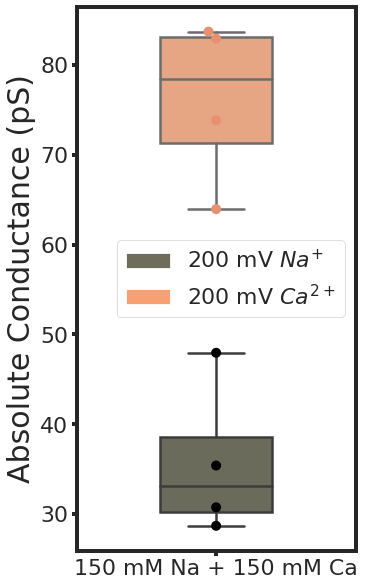

In [36]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(figsize=(5,10))

new_sys = ['EF_200_150CA']
l_box = sns.boxplot(x=ef_data['note'].to_numpy(),
            y=ef_data['conductance_sod'].to_numpy(),
            ax=ax,
            palette=['#6e6d59'],
            dodge=True,
            width=0.4,
            linewidth=2.5,
            order=new_sys)
sns.swarmplot(x=ef_data['note'].to_numpy(),
              y=ef_data['conductance_sod'].to_numpy(),
              size=10,
              ax=ax,
              palette=['black'],
              dodge=True,
              order=new_sys)

l_box = sns.boxplot(x=ef_data['note'].to_numpy(),
            y=ef_data['conductance_cal'].to_numpy(),
            ax=ax,
            palette=['#f7a072'],
            dodge=True,
            width=0.4,
            linewidth=2.5,
            order=new_sys)
sns.swarmplot(x=ef_data['note'].to_numpy(),
              y=ef_data['conductance_cal'].to_numpy(),
              size=10,
              ax=ax,
              palette=['#e79072'],
              dodge=True,
              order=new_sys)


ax.set_ylabel('Absolute Conductance (pS)',fontsize=30)
ax.set_xticklabels([ef_m[lab] for lab in new_sys])

handles = [
    Patch(facecolor=color, label=label) 
    for label, color in zip([r'200 mV $Na^{+}$', r'200 mV $Ca^{2+}$'], ['#6e6d59','#f7a072'])
]

ax.legend(handles=handles)

#l_box.artists[0].set_facecolor('#C78E52')
#l_box.artists[1].set_facecolor('#C78E52')

set_axis_boarder(ax)
plt.savefig('Figures/figure_ef_new.pdf',bbox_inches = 'tight', pad_inches=0.1, transparent=False)

In [ ]:
ef_data.to_pickle('ef_conductance.pickle')

In [ ]:
ef_data = pd.read_pickle('ef_conductance.pickle')

In [ ]:
for system, df in ef_data.groupby(['system']):
    
    fig, ax = plt.subplots()
    for rep in range(4):
        pot_data = df['potential'].iloc[rep].potential
        ax.plot(
                pot_data['coord'],
                pot_data['potential'],
                linewidth=4,
                color=cmap_open(0),)
                #label=r'$\Delta$q ' + str(row['imbalance']))
